In [52]:
import codecs
import glob
import os
import re
import time
try:
    import cPickle as pickle
except:
    import pickle

import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import altair as alt

In [53]:

def genModelPreds_biasOC_2LR_SW(data, lr_pre, lr_post, p0, d, switch_pnt):
    arr = data.to_numpy().astype(int)
    if set(np.unique(arr)) <= {0, 1}:
        outcomes = arr * 2 - 1
    else:
        outcomes = arr   # assume already -1/1

    outcomes = data.to_numpy()
    ocsDf = np.zeros(outcomes.shape)
    ocsDf[outcomes == -1] = -d
    ocsDf[outcomes == 1] = 1 - d

    # lrsDf: use lr_pre before switch_pnt, lr_post after (for each trial)
    lrsDf = np.full(outcomes.shape, lr_pre)
    lrsDf[:, switch_pnt:] = lr_post

    pred = np.zeros(outcomes.shape)
    pred[:, 0] = p0
    for ii in range(outcomes.shape[1] - 1):
        pred[:, ii + 1] = pred[:, ii] + lrsDf[:, ii] * (ocsDf[:, ii] - pred[:, ii])
    return pred


def calcActProbsPosNegOC(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds = np.asarray(modelPreds, dtype=float)           # (N, T)
    EVs = np.stack([preds * v for v in chVals], axis=0)   # (K, N, T)

    # If sftmax is "temperature": smaller -> sharper
    z = EVs / float(sftmax)

    # stabilize: subtract max over K
    z = z - np.max(z, axis=0, keepdims=True)
    expz = np.exp(z)
    probs = expz / np.sum(expz, axis=0, keepdims=True)    # (K, N, T)

    cols = [f'ch_{i:02d}' for i in range(1, preds.shape[1] + 1)]
    actProbArr = [pd.DataFrame(probs[k], columns=cols) for k in range(probs.shape[0])]
    return actProbArr

def genChoices(actProbArr):
    probs = np.stack([a.to_numpy() for a in actProbArr], axis=0)  # (K, N, T)
    cum = np.cumsum(probs, axis=0)                                 # (K, N, T)
    u = np.random.random_sample(probs.shape[1:])                   # (N, T)
    # first k where u <= cum[k]
    choices = (u[None, :, :] <= cum).argmax(axis=0) + 1
    return choices



def calcNegLogLike(choices, actProbs):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    for i in np.arange(len(actProbs)):
        chProbs[choices==i+1]=actProbs[i][choices==i+1]
    
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll, chProbs

def chanceLikelihood(choices, chanceP=0.2):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    
    chProbs[chProbs!=0]=chanceP
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll

#pre and post switch LRS
def optimize2LR_sft_fixedSM_posNegOC_p0_switch(params, choices, outcomes, switchPnt, smax=1):
    lr_pre, lr_post, d, p0 =params
    lr_pre=np.exp(lr_pre)/(np.exp(lr_pre)+1)
    lr_post=np.exp(lr_post)/(np.exp(lr_post)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1 #if softening p0
    if lr_post<0 or lr_pre<0 or smax<0 or lr_post>1 or lr_pre>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_2LR_SW(outcomes,lr_pre,lr_post,p0,d, switchPnt)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


In [54]:
def betaMuSd(mu=0.3, sd=0.05, N=1):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return np.random.beta(alpha, beta,N)

In [ ]:
params_df = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\notebooks\data\PrePost_TRUST.csv")
params_df = params_df[['PROLIFIC_PID', 'subj2LR_pre', 'subj2LR_post',	'subj2p0_4prm',	'subj2D_4prm'
]]
params_df = params_df.rename(columns={
    'subj2LR_pre': 'lrP',
    'subj2LR_post': 'lrN',
    'subj2D_4prm' : 'd',
    'subj2p0_4prm': 'p0'
})
params_df['smax'] = 1
params_df = params_df.rename(columns={'PROLIFIC_PID': 'PID'})
subjParams = params_df.copy()

In [56]:
subjParams = subjParams.set_index('PID')
datForAndrea = pd.read_csv('data/datForAndreaMerged.csv', index_col=0)
good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in subjParams.index]

subjParams = subjParams.loc[valid_candidates]

In [57]:

print("Parameter means and standard deviations in subjParams:")
for param in ['lrP','lrN','p0',"d"]:
    print(f"{param}: mean={subjParams[param].mean():.4f}, std={subjParams[param].std(ddof=1):.4f}")
    # Calculate means and stds from params_df



Parameter means and standard deviations in subjParams:
lrP: mean=0.3240, std=0.2509
lrN: mean=0.2264, std=0.2691
p0: mean=0.0774, std=0.7052
d: mean=0.6069, std=0.3471


In [58]:
import numpy as np
import pandas as pd
from scipy import stats

# --- keep your betaMuSd as-is ---
def betaMuSd(mu=0.3, sd=0.05, N=1):
    alpha = ((1-mu)/sd**2 - 1/mu) * mu**2
    beta  = alpha * (1/mu - 1)
    return np.random.beta(alpha, beta, N)

# -----------------------------
# SIM SETTINGS (yours unchanged)
# -----------------------------
nPtp = 100

#note here-- the graphs are much more identifiable when using these LR/p0 valued, as opposed to pulling them from the data. Thoughts?
lrP_mu = params_df['lrP'].mean()
lrPSTD = params_df['lrP'].std(ddof=1)
lrN_mu = params_df['lrN'].mean()
lrNSTD = params_df['lrN'].std(ddof=1)
d_mu = subjParams['d'].mean()
dSTD = subjParams['d'].std(ddof=1)
p0_mu = params_df['p0'].mean()
p0STD = params_df['p0'].std(ddof=1)
sftMax = 1
""" lrP_mu = 0.15
lrPSTD = 0.05

lrN_mu = 0.15
lrNSTD = 0.05
p0_mu = 0
p0STD = 0.5 """





nTrialsPerTarget = 22
targConting = [[.2,.65], [.35,.8], [.65,.2], [.8,.35], [.2,.65], [.35,.8], [.65,.2], [.8,.35]]
switchRange = 5
conseqContingMin = 8
conditions = ['pSoc']

# -----------------------------
# OUTCOMES
# -----------------------------

ocArr = []
for ppt in np.arange(nPtp):
    for cond in conditions:
        for conting in targConting:
            switchPnt = np.floor(np.random.random_sample()*switchRange).astype(int) + conseqContingMin
            outcomes = np.concatenate((
                (np.random.random_sample(switchPnt) < conting[0]).astype(int),
                (np.random.random_sample(nTrialsPerTarget-switchPnt) < conting[1]).astype(int)
            ))
            outcomes = np.where(outcomes == 0, -1, 1)
            ocArr.append(['{:04d}'.format(ppt+1), cond, str(conting), switchPnt] + list(outcomes))

ocDf = pd.DataFrame(
    ocArr,
    columns=['PID', 'cond', 'conting', 'switchPnt'] + [f'oc_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
) 

# =========================================================
# NO-COVARIATE PARAMETER SIMULATION (this is the key change)
# =========================================================

# 1) sample lrs directly (bounded 0..1 via Beta parameterization around lr_mu, lrSTD)
#    - simplest: treat mu constant
lrsP = betaMuSd(mu=lrP_mu, sd=lrPSTD, N=nPtp)

# 2) sample offer0 directly (bounded 0..1). use normal then clip (matches your existing style)
p0s = np.random.normal(loc=p0_mu, scale=p0STD, size=nPtp)
p0s = np.clip(p0s, -1, 1)

#3 sample d directly bounded 0..1 via Beta parameterization around d_mu, d_std)
lrsN = betaMuSd(mu=lrN_mu, sd=lrNSTD, N=nPtp)

ds = betaMuSd(mu= d_mu, sd=dSTD, N=nPtp)

print('Offer0s Mu: {:0.4f}'.format(np.mean(p0s)))
print('Offer0s Std: {:0.4f}'.format(np.std(p0s, ddof=1)))
print('lrsP Mu: {:0.4f}'.format(np.mean(lrsP)))
print('lrsP Std: {:0.4f}'.format(np.std(lrsP, ddof=1)))
print('lrsN Mu: {:0.4f}'.format(np.mean(lrsN)))
print('lrsN Std: {:0.4f}'.format(np.std(lrsN, ddof=1)))
print('d Mu: {:0.4f}'.format(np.mean(ds)))
print('d Std: {:0.4f}'.format(np.std(ds, ddof=1)))

# subjParams now  has PID/lr/offer0/d
subjParams = pd.DataFrame({
    'PID': ocDf.PID.unique(),
    'lrP': lrsP,
    'lrN' : lrsN,
    'p0': p0s,
    'd': ds 
})

# -----------------------------
# PREDICTIONS + CHOICES (unchanged)
# -----------------------------
cols = ['PID', 'cond', 'conting', 'switchPnt'] + [f'pred_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
predDf = pd.DataFrame(columns=cols)

for ptp, lrP, lrN, d, off0 in zip(subjParams.PID,  subjParams.lrP, subjParams.lrN, subjParams.d, subjParams.p0):
    outcome_cols = [col for col in ocDf.columns if col.startswith('oc_')]
    ocs = ocDf[ocDf.PID == ptp][outcome_cols]
    if ocs.shape[1] == 0 or ocs.shape[0] == 0:
        print(f"Warning: No outcome columns for PID {ptp}")
        continue
    T = ocs.shape[1]
    initPred = np.full((ocs.shape[0],), off0)
    switchPnt = ocDf.loc[ocDf.PID == ptp, 'switchPnt'].values[0]
    preds = genModelPreds_biasOC_2LR_SW(ocs, lrP, lrN, initPred, d, switchPnt)
    preds = np.concatenate((np.array(ocDf.loc[(ocDf.PID==ptp), :'switchPnt']), preds), axis=1)
    predDf = pd.concat([predDf, pd.DataFrame(preds, columns=cols)], ignore_index=True)

actProbs = calcActProbsPosNegOC(predDf.loc[:, predDf.columns.str.startswith('pred')], sftMax)
simChoices = genChoices(actProbs)

cols = ['PID', 'cond', 'conting', 'switchPnt'] + [f'ch_{i:02d}' for i in range(1, nTrialsPerTarget+1)]
simChDf = pd.DataFrame(
    np.concatenate((np.array(predDf.loc[:, :'switchPnt']), simChoices), axis=1),
    columns=cols
)
simChDf

subjParams

Offer0s Mu: 0.1217
Offer0s Std: 0.6547
lrsP Mu: 0.2877
lrsP Std: 0.2417
lrsN Mu: 0.1854
lrsN Std: 0.2409
d Mu: 0.5871
d Std: 0.3610


,PID,lrP,lrN,p0,d
0,0001,0.252901,0.000039,1.000000,0.925642
1,0002,0.800400,0.000084,-0.245408,0.458503
2,0003,0.108145,0.419906,1.000000,0.998890
3,0004,0.184428,0.023458,-1.000000,0.148584
4,0005,0.286146,0.032781,-0.844534,0.247034
...,...,...,...,...,...
95,0096,0.217944,0.000027,-1.000000,0.661817
96,0097,0.018098,0.401238,0.290892,0.942960
97,0098,0.161595,0.000989,0.632238,0.977217
98,0099,0.048167,0.017641,-0.703834,0.653467


In [59]:
initCh=simChDf.groupby('PID').mean()['ch_01']
initP=predDf.groupby('PID').mean()['pred_01']

c:\Users\mnand\miniconda3\envs\jpy39\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [60]:
""" lrRange=[-2,-0.5,0.5,2,]
p0Range=[-2,-0.5,0.5,2,]
dRange = [-2,-0.5,0.5,2,]
a1,a2,a3 =np.meshgrid(lrRange,p0Range, dRange)
a1=a1.reshape(16,)
a2=a2.reshape(16,)
a3=a3.reshape(16,) """
a1=[0]
a2=[0]
a3=[0]
timer=time.time()
for lrs, p0Val, d in zip(a1, a2, a3):
    fitsDF=pd.DataFrame(columns=['lrP', 'lrN', 'p0','d','nll'], index=subjParams.PID)
    nll=10000;
    for PID in subjParams.PID:
        switchPnt = ocDf.loc[ocDf.PID == PID, 'switchPnt'].values[0]
        result=sp.optimize.minimize(optimize2LR_sft_fixedSM_posNegOC_p0_switch, (lrs,lrs, d, p0Val),(simChDf.loc[(simChDf.PID==PID),'ch_01':], ocDf.loc[(ocDf.PID==PID), 'oc_01':],switchPnt,sftMax),bounds=((-10,10),(-10,10),(-10,10),(-10,10)))
        fitsDF.loc[PID,'lrP']=np.exp(result.x[0])/(np.exp(result.x[0])+1)
        fitsDF.loc[PID,'lrN']=np.exp(result.x[1])/(np.exp(result.x[1])+1)
        fitsDF.loc[PID,'d']=np.exp(result.x[2])/(np.exp(result.x[2])+1)
        fitsDF.loc[PID,'p0']=np.exp(result.x[3])/(np.exp(result.x[3])+1)*2 - 1
        fitsDF.loc[PID,'nll']=result.fun
        
        # if result.fun<nll:
        #     nll=result.fun
        #     bestLR=np.exp(result.x[0])/(np.exp(result.x[0])+1)
        #     bestP0=np.exp(result.x[1])/(np.exp(result.x[1])+1)
        #     bestNLL=nll

print('finished at: {:02f}'.format(time.time()-timer))
fitsDF
    

finished at: 155.918884


,lrP,lrN,p0,d,nll
PID,,,,,
0001,0.28117,0.011904,0.999909,0.999955,243.62909
0002,0.832443,0.000045,0.316841,0.43523,254.915635
0003,0.130727,0.536269,0.999883,0.999955,235.574386
0004,0.123152,0.000045,-0.999909,0.070812,256.448273
0005,0.170089,0.0416,-0.879189,0.131673,264.62349
...,...,...,...,...,...
0096,0.20821,0.000045,-0.944972,0.545286,252.203971
0097,0.160672,0.409072,0.480783,0.845592,260.527391
0098,0.137664,0.05898,0.775816,0.999955,261.917322


In [61]:
r,p=stats.pearsonr(fitsDF['p0'],subjParams['p0'])
print('fitXog p0: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['lrN'],subjParams['lrN'])
print('fitXog lrN: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['lrP'],subjParams['lrP'])
print('fitXog lrP: r={:.02f}, p={:.03f}'.format(r,p))
r,p=stats.pearsonr(fitsDF['d'],subjParams['d'])
print('fitXog d: r={:.02f}, p={:.03f}'.format(r,p))

fitXog p0: r=0.95, p=0.000
fitXog lrN: r=0.92, p=0.000
fitXog lrP: r=0.83, p=0.000
fitXog d: r=0.86, p=0.000


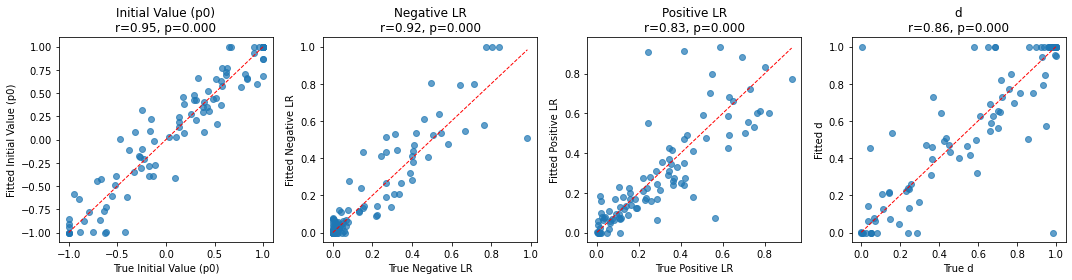

In [62]:
import matplotlib.pyplot as plt

params = ['p0', 'lrN', 'lrP', 'd']
titles = {'p0': 'Initial Value (p0)', 'lrN': 'Negative LR', 'lrP': 'Positive LR', 'd': 'd'}

plt.figure(figsize=(15, 4))
for i, param in enumerate(params):
    plt.subplot(1, 4, i+1)
    plt.scatter(subjParams[param], fitsDF[param], alpha=0.7)
    plt.xlabel(f"True {titles[param]}")
    plt.ylabel(f"Fitted {titles[param]}")
    r, p = stats.pearsonr(fitsDF[param], subjParams[param])
    plt.title(f"{titles[param]}\nr={r:.2f}, p={p:.3f}")
    plt.plot([subjParams[param].min(), subjParams[param].max()],
             [subjParams[param].min(), subjParams[param].max()], 'r--', lw=1)

plt.tight_layout()
plt.show()

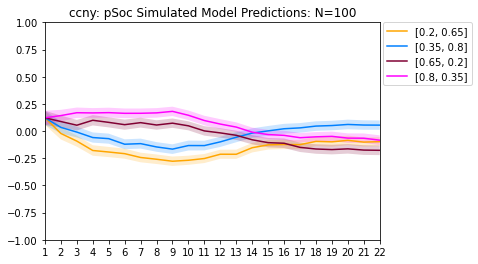

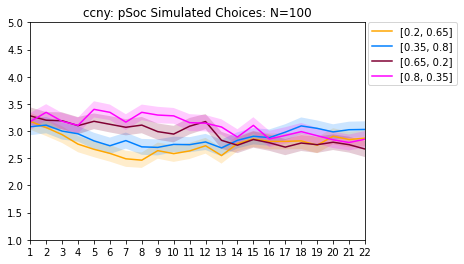

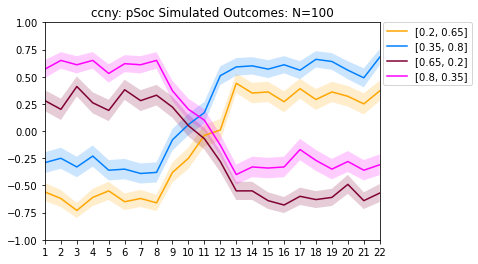

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


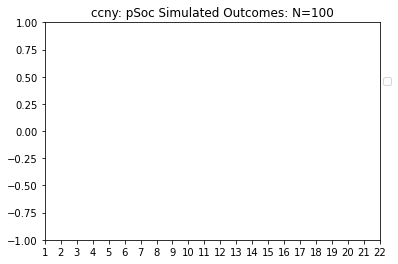

In [63]:
# plt.plot(simChDf.groupby('conting').mean().iloc[0,2:].transpose())

muCrvs=predDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs=(predDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()
muCrvs_ch=simChDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs_ch=(simChDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()
muCrvs_oc=ocDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).mean().reset_index()
steCrvs_oc=(ocDf.drop(columns=['cond', 'PID', 'switchPnt']).groupby(['conting']).std()/np.sqrt(nPtp)).reset_index()


colors=np.array([[1,.65,0], [0,.5,1], [.5,0,.2], [1,0,1]])
ind=0;
for conting in muCrvs.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu=np.squeeze(muCrvs.loc[(muCrvs.conting==conting), 'pred_01':].transpose())
    ste=np.squeeze(steCrvs.loc[(steCrvs.conting==conting), 'pred_01':].transpose())

    plt.plot(np.arange(1,mu.shape[0]+1),mu, c=col,label=conting)
    plt.fill_between(np.arange(1,mu.shape[0]+1),mu-ste,mu+ste, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Model Predictions: N={:d}'.format(cond,nPtp))
plt.legend(loc=(1.01,.71))
plt.ylim([-1,1])
plt.xlim([1,mu.shape[0]])
plt.xticks(np.arange(1,mu.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.show()

ind=0
for conting in muCrvs_ch.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu_ch=np.squeeze(muCrvs_ch.loc[(muCrvs_ch.conting==conting), 'ch_01':].transpose())
    ste_ch=np.squeeze(steCrvs_ch.loc[(steCrvs_ch.conting==conting), 'ch_01':].transpose())

    plt.plot(np.arange(1,mu_ch.shape[0]+1),mu_ch, c=col, label=conting)
    plt.fill_between(np.arange(1,mu_ch.shape[0]+1),mu_ch-ste_ch,mu_ch+ste_ch, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Choices: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([1,5])
plt.xlim([1,mu_ch.shape[0]])
plt.xticks(np.arange(1,mu_ch.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('simCh_n{}_Grant.png'.format(nPtp))
plt.show()

ind=0
for conting in muCrvs_oc.conting.unique():
    col=colors[ind%4]
    ind+=1
    mu_oc=np.squeeze(muCrvs_oc.loc[(muCrvs_oc.conting==conting), 'oc_01':].transpose())
    ste_oc=np.squeeze(steCrvs_oc.loc[(steCrvs_oc.conting==conting), 'oc_01':].transpose())

    plt.plot(np.arange(1,mu_oc.shape[0]+1),mu_oc, c=col, label=conting)
    plt.fill_between(np.arange(1,mu_oc.shape[0]+1),mu_oc-ste_oc,mu_oc+ste_oc, alpha=.2, facecolor=col)

plt.title('ccny: {} Simulated Outcomes: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([-1,1])
plt.xlim([1,mu_oc.shape[0]])
plt.xticks(np.arange(1,mu_oc.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.show()

plt.title('ccny: {} Simulated Outcomes: N={:d}'.format(cond, nPtp))
plt.legend(loc=(1.01,.71))    
plt.ylim([-1,1])
plt.xlim([1,mu_oc.shape[0]])
plt.xticks(np.arange(1,mu_oc.shape[0]+1))
# plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('simOc_n{}_Grant.png'.format(nPtp))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

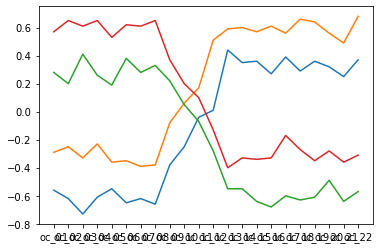

In [64]:
plt.plot(ocDf.groupby('conting').mean().loc[:,'oc_01':].transpose())
plt.show